In [3]:
from utils.task import add_task_identity
from utils.analysis import get_all_hiddens, minimize_speed, get_attractors, plot_pca
from utils.model import MultitaskRNN, run_model, plot_behavior
from utils.utils import get_model

import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import os
os.environ['KMP_WARNINGS'] = '0'

# Network behavior

In [4]:
model_name = "delaygo_delayanti_255"
period_duration=400
plot_behavior(model_name, period_duration=period_duration)

TypeError: plot_behavior() missing 1 required positional argument: 'tasks'

# Fixed Points

In [5]:
rnn, tasks = get_model(model_name)

all_hiddens = get_all_hiddens(rnn, tasks)

period = "delay"
stimulus = 2
task_idx = 0

input = add_task_identity(tasks[task_idx].get_input(period, stimulus), task_idx, len(tasks))
input

tensor([1., 0., 0., 1., 0.])

In [6]:
num_timesteps = 10000
num_last = 100

attractors = get_attractors(rnn, input, all_hiddens, num_timesteps, num_last)

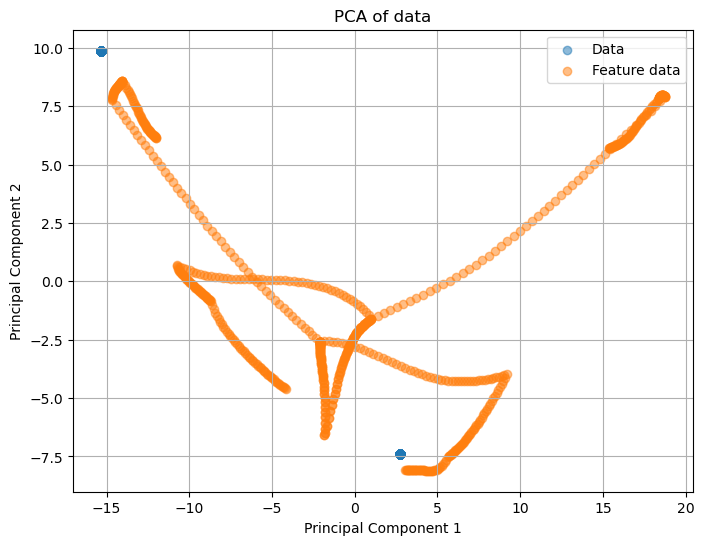

In [7]:
attractors_2d = attractors.reshape(-1, attractors.shape[-1])
plot_pca(attractors_2d.detach().numpy(), all_hiddens.detach().numpy(), plot_feature_data=True)  # convert tensors to numpy arrays for use with sklearn

In [8]:
lr = 0.1
q_thresh = 1.0
r = 0.1
iters = 10000

k = all_hiddens.size(0)
num_samples = int(k * r)  # Calculate the number of samples as 10% of k

indices = torch.randperm(k)[:num_samples]  # Randomly permute the indices and select the first num_samples
sampled_hiddens = all_hiddens[indices]  # Select the sampled hidden points using the sampled indices

inputs = input.repeat(sampled_hiddens.shape[0], 1)

fps = minimize_speed(rnn, inputs, sampled_hiddens, lr, iters, q_thresh)

RuntimeError: The size of tensor a (6400) must match the size of tensor b (80) at non-singleton dimension 0

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


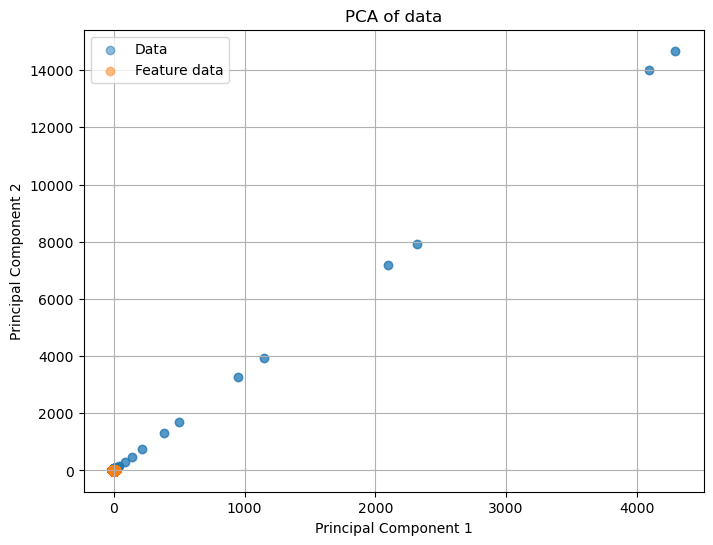

In [8]:
plot_pca(fps.detach().numpy(), all_hiddens.detach().numpy(), plot_feature_data=True)  # convert tensors to numpy arrays for use with sklearn

255